## PQ Prediction with HuBERT using a Deep Neural Net 

In the last notebook, we used HuBERT layers to predict the PQ Representation of the audio clips in the Perceptual Voice Qualities Database (PVQD). We used a naive aggregation technique to do this (simply averaging over the time steps), but what if instead we decided to try and take advantage of the temporal information to perform prediction? 

We may *want* to use deep neural networks, because they are super duper cool and powerful, but we have to ask if it is the best tool for the job. Given that the PQ Representation is a vector that represents speaker identity, which can be thought of as the time-invariant characteristics of speech (mostly), will the temporal information increase predictive performance? 

In [2]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
sys.path.append("../")

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torch.optim as optim


import IPython
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import *

import time
from collections import OrderedDict # Not necessary

# Progress bar
from tqdm import tqdm

In [3]:
# Load in the HuBERT Model
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bundle = torchaudio.pipelines.HUBERT_BASE
hubert_model = bundle.get_model().to(device)
hubert_model.eval() # make sure it's in eval mode

print("Sample Rate:", bundle.sample_rate)
print(device)

Sample Rate: 16000
cuda


In [4]:
# Load in the Data 
## Load in the DataFrame
y_train = pd.read_csv('../data/pvqd/train_test_split/y_train.csv', index_col=0)
y_val = pd.read_csv('../data/pvqd/train_test_split/y_val.csv', index_col=0)

# Same inefficient code as before!

data_path = "../data/pvqd/audio_clips/"
audio_files = os.listdir(data_path)
speaker_ids = [extract_speaker(audio_file) for audio_file in audio_files]

# Assertion to make sure speaker_ids matches y_train['File']
i = 0
for spk_id in y_train["File"]:
    try:
        assert spk_id in speaker_ids
    except:
        print(spk_id)
        i+=1

# Dictionary to Link Speaker ID to Audio File for O(1) access
speaker_file_dict = {}
for i in range(0, len(speaker_ids)):
    speaker_file_dict[speaker_ids[i]] = os.path.join(data_path, audio_files[i])

### First things first, we gotta make the data compatible with PyTorch 

PyTorch is a very powerful package that allows us to process data in fast and remarkable ways. Now, the way to take advantage of PyTorch's [Dataset](https://pytorch.org/tutorials/ beginner/data_loading_tutorial.html) class. Using this class, you can train in parallel, and easily modify batch size (the number of input samples your network considers per training update)

Below, we're going to load in the hubert model and implement the class HubertDataset, which will take in a a dataframe of labels, the speaker-to-wavfile array, and a hubert model, and will return the sixth layer of the hubert features and the labels.

In [5]:
## TODO: Implement the Dataset function __getitem__ 

class HubertDataset(Dataset):
    def __init__(self, dataframe, spk_wav_arr, hubert_model, device):
        self.dataframe = dataframe
        self.spk_wav_arr = spk_wav_arr # array that links speaker id and 
        self.pad_len = 1135467 # Max seq length

    def __len__(self):
        # Return the total number of data samples
        return len(self.dataframe)

    # TODO: Implement the __getitem__ function
    # Given an index, return the features and the labels
    def __getitem__(self, index):
        # Retrieve a single row from the DataFrame
        single_row = self.dataframe.values[index, :]
        speaker_id = single_row[0]
        audio_file = self.spk_wav_arr[speaker_id]

        waveform, sample_rate = torchaudio.load(audio_file)

        if sample_rate != bundle.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

        # Let's take a fixed length-- pad the waveform with 0s up to the max file length
        # Question: Should we be padding with 0s?
        to_pad = self.pad_len - waveform.shape[-1]
        waveform = F.pad(waveform, (0, to_pad))

        # TODO: Downmix Stereo to Mono & Get rid of the channels dimension
        if len(waveform.shape) == 2 and (waveform.shape[0] == 2):
            waveform = torch.mean(waveform, dim=0)

        else:
            waveform = waveform.squeeze(0)

        # Load in the Labels
        labels = torch.from_numpy(single_row[1:].astype(float))

        

        return waveform, labels


def process_wavform(waveform, hubert_model):
    # Extract the HuBERT layers like before
    features = hubert_model.extract_features(waveform)
    features = features[0]

    features = features[5]

    # Have to swap the axes, since we want the hubert dimension to be the channels
    features = torch.swapaxes(features, 1, 2)

    # Remove the first dimension
    features = features.squeeze(0)

    return features

### Note: PyTorch's Dataset class is *incredibly* flexible

There's no need to make it load a pandas DataFrame at all. You could store everything on disk, and have the index be associated with a file location.

Let's use our created HubertDataset class to create a DataLoader

In [6]:
train_dataset = HubertDataset(y_train, speaker_file_dict, hubert_model, device)

batch_size = 8 # Set the batch size
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

## The Moment You've All Been Waiting for: Let's Build a Neural Network

For the purposes of this workshop, we're going to just build a convolutional neural network. There are other ways to model speech or sequential data more broadly, such as using a Transformer (or a Conformer if you want to combine the two). We're going to keep it simple. Feel free to modify the network though, Torchaudio makes it pretty easy! (https://pytorch.org/audio/main/generated/torchaudio.models.Conformer.html for example).

In [7]:
# NOTE: This class is not implemented, how do I put this, well. How would you change this class to make it more flexible and better?
class ClassifierModel(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv_block1 = nn.Sequential(OrderedDict([
        ('conv', nn.Conv1d(768,256,5, padding=2)),
        ('norm', nn.InstanceNorm1d(256)),
        ('relu', nn.ReLU()),
      ]))

      self.conv_block2 = nn.Sequential(OrderedDict([
        ('conv', nn.Conv1d(256,256,5, padding=2)),
        ('norm', nn.InstanceNorm1d(256)),
        ('relu', nn.ReLU()),
      ]))

      self.lstm = nn.LSTM(256, 512, num_layers=2, bidirectional= True)
      self.pool = nn.MaxPool1d(5, 2, 2)
      
      self.final_layer = nn.Linear(3548 * 512, 5)

    def forward(self, x):
      x = self.conv_block1(x)
      x = self.conv_block2(x)

      x = torch.swapaxes(x, 1, 2)

      x, _ = self.lstm(x)
      x = self.pool(x)

      x = torch.flatten(x, start_dim=1)

      x = self.final_layer(x)

      return x

In [8]:
# Load in the Model
model = ClassifierModel()
model.to(device)
model

ClassifierModel(
  (conv_block1): Sequential(
    (conv): Conv1d(768, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (norm): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
  )
  (conv_block2): Sequential(
    (conv): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (norm): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU()
  )
  (lstm): LSTM(256, 512, num_layers=2, bidirectional=True)
  (pool): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (final_layer): Linear(in_features=1816576, out_features=5, bias=True)
)

Quick Sanity Check: We can access a datapoint and run it through the model, right?

In [9]:
wavform, label = train_dataset.__getitem__(1)
wavform = wavform.to(device).unsqueeze(0)
print(wavform.shape)

# Get the features
sample = process_wavform(wavform, hubert_model)

sample = sample.unsqueeze(0) # Add a dimension to simulate batch_size
out = model(sample)
print(sample.shape)
print(out)

del sample 
del out
del wavform

torch.Size([1, 1135467])


/home/robbizorg/miniconda3/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([1, 768, 3548])
tensor([[-0.0260,  0.0123,  0.0194,  0.0123, -0.0005]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


How many parameters does our neural network have?

In [10]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Number of Params: %s"% pytorch_total_params)

Number of Params: 19847685


## We have our dataset, we have our model--what's next? The training loop!

Modern deep learning methods use learning algorithms, usually based off of [Stochastic Gradient Descent (SGD)](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31), that guide the parameters of a neural network towards configurations that yield meaningful connections between the input and output. For this task, we're going to use a simple L2 (MSE) loss coupled with the Adam Optimizer (a variant of SGD with Momentum).  

Ask yourself though, is this the right loss? Are there better losses out there? 

In [11]:
# Create the Optimizer
# First, put in the parameters you want to update (in this case, all of the parameters)
# Learning Rate: Also known as the step size. It's basically how big of updates we want to take. Finding the right learning rate is an art
# Weight Decay: Essentially an L2 Regularization on the weights. Helps keep the parameters small and under control
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-4) 

# Create the criterion or loss function, we'll be using a simple MSE loss
criterion = nn.MSELoss()

# Epochs: Aka the number of times you want to load through the dataset
# Going to have to experiment a bit to see what your computer can handle!
epochs = 10 

### The Training Loop

The nice thing about PyTorch is that, no matter how complicated the model or parallel computing setup or training procedure, the training loop is going to look roughly the same. The pseudocode is usually going to look like this:

```
for epoch in epoch_num:
    for batch in dataloader:
        // Zero the Gradients
        optimizer.zero_grad()

        // Extract the inputs and labels from the batch
        inputs, labels = batch

        // Preprocess the Data
        inputs = process_data(inputs)

        // Forward Pass
        outputs = model(inputs)

        // Compute loss
        loss = criterion(outputs, labels)

        // Backward pass and update
        loss.backward()
        optimizer.step()

```

And that's it! There might be some slight variations, but, for the most part, every PyTorch training loop is going to have this same structure. At least for me, I usually start looking at the training loop when I'm trying to understand a deep learning codebase since it allows you to track the flow of the data through the model and processing. A simple but important fact: Everything that you need to pay attention to when looking how to train a model will be present in the training loop


Using the above pseudocode, let's try and implement our own training loop! I provided the for loops for you. tqdm is a nice package for visualizing a progress bar.

In [13]:
## The Training Loop!
model.train() # Put our model into training mode (important! This can effect how the model is run)
hubert_model.eval() # Make sure it's in eval!
avg_losses = [] # Keep track of the loss per epoch!
losses = []
step = 0 # A variable to let us know how many updates we've done
for epoch in range(0, epochs):
    # Track the average loss per epoch
    avg_loss = 0
    avg_loss_step = 0

    # Create the progress bar
    progress = tqdm(data_loader)
    for i, (waves, labels) in enumerate(progress):
        # TODO: Implement the training loop based on the pseudocode provided above

        optimizer.zero_grad()

        with torch.no_grad():
            inputs = process_wavform(waves.to(device), hubert_model).to(device).float()

        labels = labels.to(device)

        outputs = model(inputs).float()

        loss = criterion(outputs, labels.float())
        loss.backward()

        optimizer.step()

        # Bookkeeping and Setting the Progress Bar
        avg_loss += loss.item()
        avg_loss_step += 1
        step += 1

        progress.set_postfix(
            loss = avg_loss / avg_loss_step,
            epoch = epoch + i / len(data_loader)
        )

        avg_losses.append(avg_loss / avg_loss_step)


100%|██████████| 30/30 [00:41<00:00,  1.37s/it, epoch=9.97, loss=85.9]


Text(0, 0.5, 'Loss')

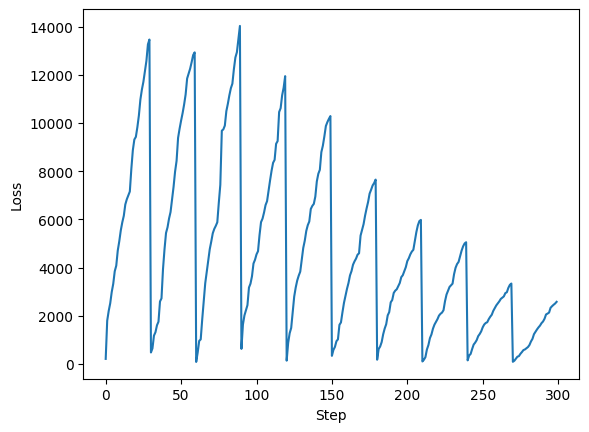

In [15]:
# Quick Plot of the Losses!
sns.lineplot(avg_losses)
plt.xlabel("Step")
plt.ylabel("Loss")

## Now that we've trained our model, let's evaluate it!

In [32]:
val_dataset = HubertDataset(y_val, speaker_file_dict, hubert_model, device)

# Can just use a batch_size of 1, just computing loss
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle = False)

In [33]:
labels

tensor([[21.0000,  8.8333,  3.5000, 11.8333,  2.3333]], device='cuda:0',
       dtype=torch.float64)

In [42]:
# Put model into eval mode
model.eval()

losses = torch.zeros((len(val_data_loader), 5)).to(device)
with torch.no_grad():
    for i, (waves, labels) in enumerate(val_data_loader):


        inputs = process_wavform(waves.to(device), hubert_model).to(device).float()
        
        # If doing a batch_size = 1, might have to unsqueeze
        inputs = inputs.unsqueeze(0)

        labels = labels.to(device)

        outputs = model(inputs).float()

        # Append the squares
        losses[i,:] = (labels - outputs)**2

print("Average RMSE Loss %s" % torch.sqrt(losses.mean()))
print("RMSE per PQ %s" % torch.sqrt(losses.mean(axis = 0)))



Average RMSE Loss tensor(14.0729, device='cuda:0')
RMSE per PQ tensor([13.0158, 11.9063, 14.3974, 17.1063, 13.3848], device='cuda:0')


## Takeaways and Questions

Congratulations! You trained and designed a neural network for prediction. This is essentially a big part of what it means to do "deep learning" research. There's a lot of questions left over, improvements to be done--generally, there's a ton to try and work on. 

Here are some questions to leave you with:
* What happens if you try different architectures? Different learning rates? These things all take time to explore, and, as you work with these tools more, you'll develop an intution.
* How might you speed up training... besides just using a GPU! There's [parallelization](https://pytorch.org/docs/stable/generated/torch.nn.DataParallel.html), [autocasting](https://pytorch.org/docs/stable/amp.html), [quantization](https://pytorch.org/blog/quantization-in-practice/), and much more! But more simply, how might restructure the data, or the above code, to run faster more generally? Ex--what if we took in less data, or explored truncation instead of padding?
* In the end, was it worth using a deep learning model for this prediction task? Is it better to stick with the classic ML methods, or do you think more performance can be squeezed out of neural nets?

### One final note

It may not seem like it, but what you just did was research! I designed this notebook to explore something I had been wanting to do for a bit, namely how we could use HuBERT's representations for prediction of perceptual qualities. I honestly didn't know this would turn out, and, at time of writing, arguably still don't. By completing this notebook, you've explored something that people haven't really explored before! And that's all research realy is. 